<a href="https://colab.research.google.com/github/NoorFatimaMemon/DeepLearning/blob/main/25_Neural_Style_Transfer/25_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural style transfer (NST)**

NST is a process that uses a CNN to generate a new image that preserves the content of one image (e.g., a photo of a person) and adopts the style (e.g., brush strokes, color patterns) of another image (e.g., a painting).

For example, let’s take an image of **Eiffel Tower** (content image) and **The Starry Night** by Vincent van Gogh (Style Image):

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a8/Tour_Eiffel_Wikimedia_Commons.jpg" width="300px" height="500px"/>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/800px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg" width="300px"/>

Step 1: Imports and configure modules

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl  # alias for matplotlib
import numpy as np
import PIL.Image    # for image creation
import time
import functools  # used later for decorators
import IPython.display as display
import tensorflow_hub as hub

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'  # Sets TensorFlow Hub to use compressed models (smaller size).
# COMPRESSED is fine when you have little disk space but a faster internet connection.
# UNCOMPRESSED is great when you are not limited to Edge Computing and internet can be negotiable

In [2]:
# Configures plot size and disables grids
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [3]:
# Converts a Tensor (float, 0–1) to a displayable image (PIL.Image)
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

# Step 2: Load Images

Downloads **Eiffel Tower** as the content image and **The Starry Night** as the style image

In [4]:
content_path = tf.keras.utils.get_file('eiffel.jpg', 'https://upload.wikimedia.org/wikipedia/commons/a/a8/Tour_Eiffel_Wikimedia_Commons.jpg')
style_path = tf.keras.utils.get_file("starry_night.jpg", 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/800px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

5279797/5279797 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
244847/244847 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Load and preprocess image
def load_img(path_to_img):
    # Resizes it so the larger dimension = 512 while keeping aspect ratio
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3) # Decodes binary string into a 3-channel image tensor (RGB)
    img = tf.image.convert_image_dtype(img, tf.float32) # Converts the image's data type to float32 & normalizes pixel values to the range [0, 1]
    shape = tf.cast(tf.shape(img)[:-1], tf.float32) # Gets the image's height & width (excluding channel dimension)
    long_dim = max(shape)   # Determines which side (height or width) is longer to scale it to to 512
    scale = max_dim / long_dim  # scaling factor to resize the image
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :] # Adds a batch dimension to the image. Most tf models expect input in the format [batch_size, height, width, channels]. This converts a shape like [512, 400, 3] to [1, 512, 400, 3]
    return img

In [6]:
# Display helper
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

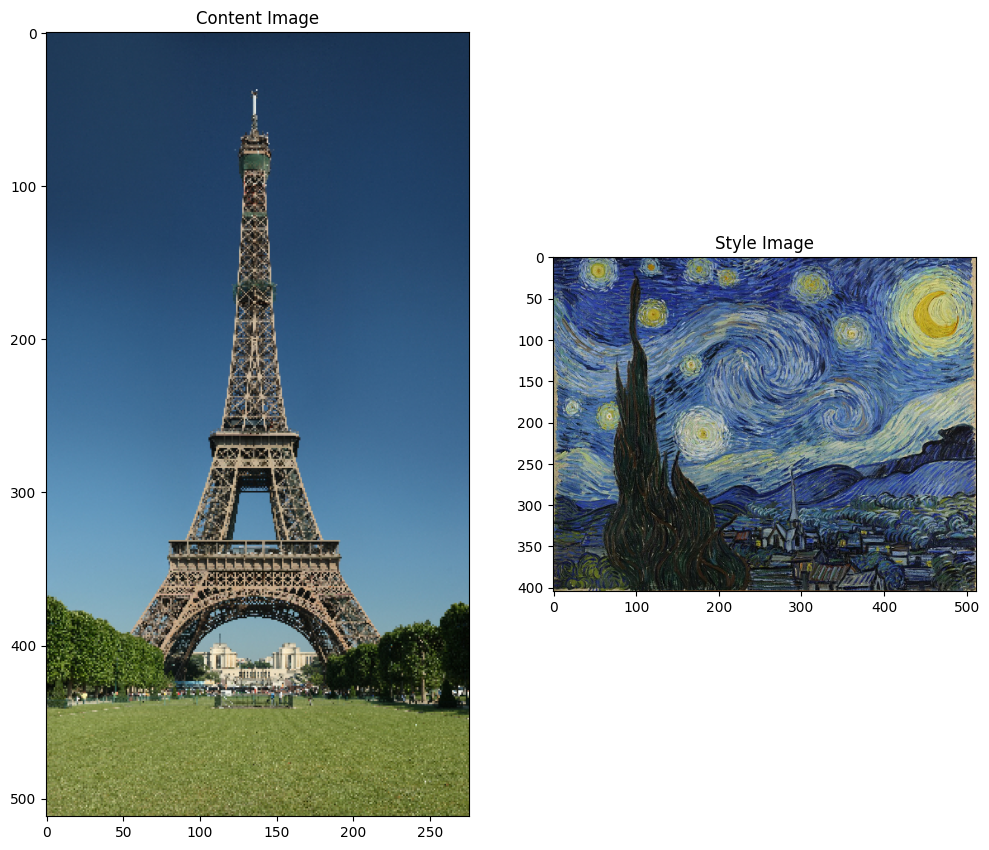

In [8]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# Step 3: Use pre-trained TF Hub model for fast transfer

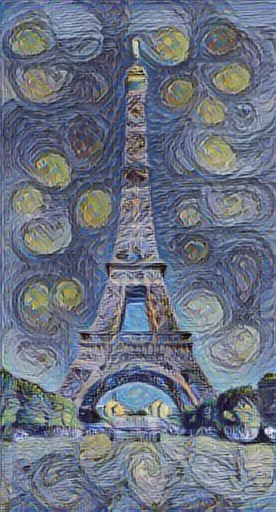

In [9]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
# Converts images to tensors; [0] selects the 1st element of the model's output tuple
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

# **Content & Style Representations with VGG19**

1. Use model's intermediate layers to extract image's content & style representations.

2. In CNNs like VGG19, different layers capture different types of features:

    a. Early layers capture low-level features (e.g., edges, textures).

    b. Later layers capture high-level features (e.g., object parts like eyes).

3. VGG19 is a pretrained image classification model commonly used for style transfer.
4. These intermediate layer activations are crucial for defining both style and content, which are matched to target representations at selected layers.

In [10]:
# Preprocess the input image:
  # - Scale pixel values from [0, 1] to [0, 255]
  # - Convert RGB to BGR
  # - Subtract ImageNet mean pixel values
x = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


TensorShape([1, 1000])

In [11]:
# Decode the top-5 predictions from the VGG19 output probabilities
# Convert the tensor to a NumPy array, then decode the predictions
# Each prediction is (class_id, class_name, probability)
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[('stupa', np.float32(0.31453973)),
 ('palace', np.float32(0.15887997)),
 ('church', np.float32(0.14945574)),
 ('castle', np.float32(0.10787009)),
 ('bell_cote', np.float32(0.031113742))]

# List Layers to Use

In [12]:
# Loads VGG19 without classification head.
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [13]:
# Selects intermediate layers representing content and style
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1',
                'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print(num_content_layers)
print(num_style_layers)

1
5


**Why we use intermediate layers for style and content?**

Neural networks learn to recognize images by breaking them down step-by-step in different layers. Early layers see simple things like edges, while deeper layers understand objects and shapes.

The middle layers (called intermediate layers) capture both what’s in the image (content) and how it looks (style). That’s why we use them when we want to separate or combine style and content in images.

# Build Feature Extractor

In [14]:
# Returns a Keras model outputting intermediate layer values
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  return tf.keras.Model([vgg.input], outputs)

In [15]:
# Extracts style feature maps from the style image
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_48']
Received: inputs=Tensor(shape=(1, 405, 512, 3))
  warnings.warn(msg)


# Compute Gram Matrix for Style

### **What’s a Gram matrix?**
*   At each image location, we take feature values (a vector).
*   Multiply it by itself to get an outer product.
*   Do this for all pixels and average the results.

This Gram matrix can be calculated for a particular layer as:

## $$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function

## **Calculate style**
In neural style transfer:
*   Content = objects and structure in the image
*   Style = colors, textures, and patterns

To capture style, we use a Gram matrix, which shows how different features (like colors or textures) relate to each other.

In [16]:
# Computes Gram matrix (correlation between feature maps)
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

# Extract Style and Content Features

In [17]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
    return {'content':content_dict, 'style':style_dict}

In [18]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(1, 512, 276, 3))
  warnings.warn(msg)


# Loss Functions

## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the MSE for image's output relative to each target, then take the weighted sum of these losses.

In [19]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image) # to contain the image to optimize

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(1, 405, 512, 3))
  warnings.warn(msg)


In [20]:
# Ensures pixel values are between 0 and 1.
def clip_0_1(image):
  return tf.clip_by_value(image, 0.0, 1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
# To optimize this, use a weighted combination of the two losses to get the total loss
style_weight=1e-2
content_weight=1e4

In [21]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

# Optimization Step

In [22]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

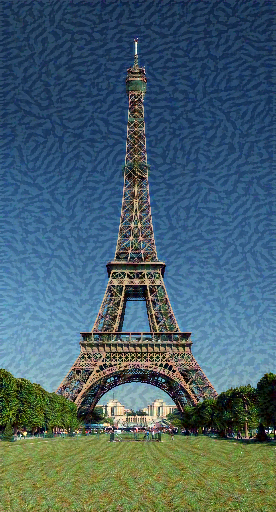

In [23]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

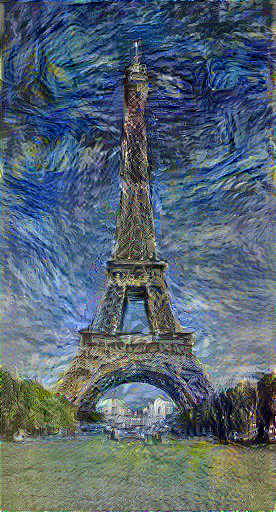

Train step: 1000
Total time: 4697.5


In [24]:
start = time.time()
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# Total Variation Loss (Smoothness Regularization)

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*

In [25]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]
  return x_var, y_var

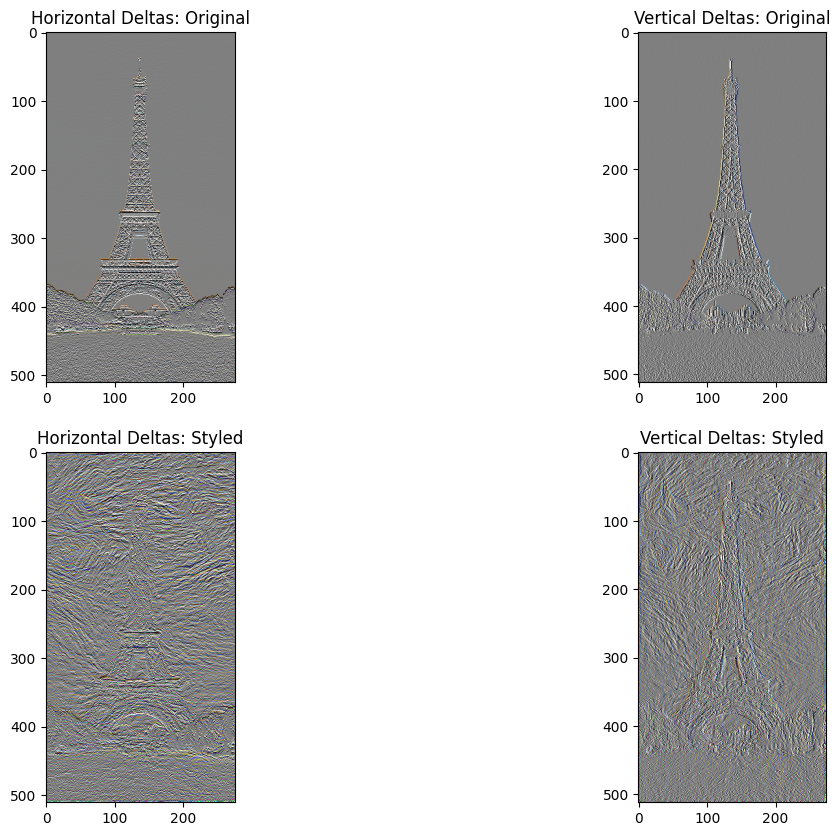

In [26]:
x_deltas, y_deltas = high_pass_x_y(content_image)
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")
plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")
x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")
plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

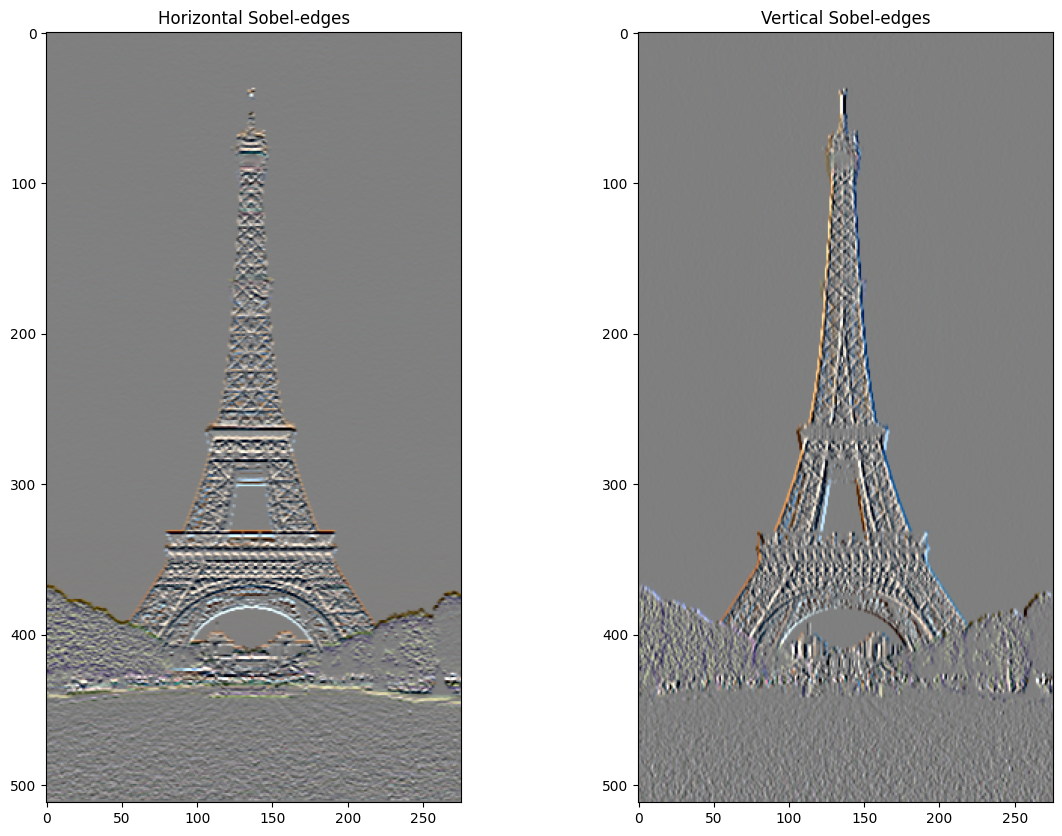

In [27]:
plt.figure(figsize=(14,10))
sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [28]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_loss(image).numpy()
tf.image.total_variation(image).numpy()

array([85232.99], dtype=float32)

# **Re-run the optimization**

Choose a weight for the `total_variation_loss` and include it in the `train_step` function

In [29]:
total_variation_weight=30

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

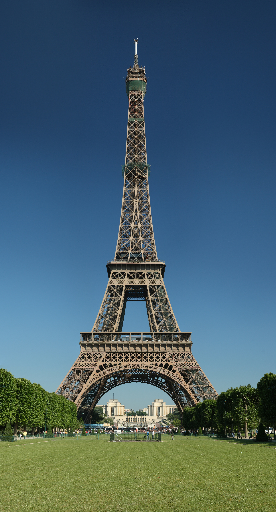

Train step: 1000
Total time: 6.4


In [32]:
# Reinitialize the optimization variable & run it
image = tf.Variable(content_image)
# Recreate the optimizer after reinitializing the image variable
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

start = time.time()
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))